Explain what each section does.

Reference equations from the paper

Add Visualization Section

No interpretation or benchmarking of results.
Compute and display average + standard deviation.

Compare results against a baseline (e.g., EFPE or noisy estimates).

Add a markdown cell summarizing conclusions.
sweeping over values of k, gamma, or N.

Capture simulation parameters and results for reproducibility
Store results in a CSV or pickle for future use
Plot confidence intervals across M runs


# SIMULTANEOUS COMMUNICATION AND PARAMETER ESTIMATION OF PAULI CHANNELS Simulation using NetSquid
This notebook simulates the Simultaneous Communication and Parameter Estimation (SCAPE) protocol for Pauli channels using NetSquid. 

## Introduction
**Communicating Parties:**  
- Alice: transmitter  
- Bob: receiver

**Parameters:**  
- `k`: repetition factor (≥ 3)  
- `N`: total channel uses (divisible by 3k)  
- `m`: message of length N/k (split into m_X, m_Y, m_Z) 

---

### Step 1: Transmission and Decoding (for each j ∈ {X, Y, Z})
1. Alice picks message `m_j`.  
2. Encode with k-repetition: `E_k(m_j)`.  
3. Map bits to qubits in basis j:  
   - 0 → |0_j⟩  
   - 1 → |1_j⟩  
   → produces |ψ_j⟩.  
4. Send |ψ_j⟩ through Pauli channel.  
5. Bob receives state ρ_j = N(|ψ_j⟩⟨ψ_j|).  
6. Bob measures in basis j → estimate `Ê_k(m_j)`.  
7. Bob decodes by majority vote → `m̂_j`.  

### Step 2: Error Estimation (for each j ∈ {X, Y, Z})
8. Bob re-encodes: `Ĕ_k(m̂_j)`.  
9. Compare `Ê_k(m_j)` and `Ĕ_k(m̂_j)` bitwise to estimate error rate:  
$$
\hat{\epsilon}_j = \frac{3}{N} \sum_{\ell=1}^{N/3} I\!\big(\hat{E}_k(m_j)[\ell] \neq \check{E}_k(m_j)[\ell]\big)
$$

### Step 3: Pauli Parameter Estimation
10. Combine error rates \(\hat{\epsilon}_X, \hat{\epsilon}_Y, \hat{\epsilon}_Z\).  
11. Solve linear system to estimate Pauli parameters:  
$$
\hat{p} = A^{-1} \hat{\epsilon}
$$

---

**Outputs:**  
- Estimated Pauli channel parameters \((\hat{p}_I, \hat{p}_X, \hat{p}_Y, \hat{p}_Z)\).
---
## Notes

### NetSquid basis vectors
- `ns.s0` → |0⟩  
- `ns.s1` → |1⟩  
- `ns.h0` → |+⟩  
- `ns.h1` → |−⟩  
- `ns.y0` → |+i⟩  
- `ns.y1` → |−i⟩

# Imports

In [1]:
import netsquid as ns
import numpy as np
from enum import Enum, auto
import time
from functools import reduce
import os
from multiprocessing import get_context
from tqdm import tqdm

from scape_tools import (
    Basis,
    operators,
    kets,
    get_pauli_parameters,
    pauli_to_bsc_error_rates,
    bsc_error_rates_to_pauli,
    diamond_norm_distance,
    simulate_chunk,
)

# Configuration of the parameters

In [2]:
np.random.seed(41)

M = 25 # number of simulations

# SCAPE parametres:
k = 13   # number of symbol repetitions
N = 10000 # channel uses
gamma = 0.1 # corr matrix parameter

message_length = N // k
print('message_length', message_length)

message_length 769


# Tools

## Message Transfer
Simulate noisy transmission of messages through a Pauli channel.

In [3]:
def transfer_message(message, pauli_parameters, basis, nproc=None):
    msg = np.asarray(message, dtype=np.int8)
    nproc = nproc or os.cpu_count()
    chunks = [c.tolist() for c in np.array_split(msg, nproc) if c.size]
    with get_context("spawn").Pool(processes=nproc) as pool:
        parts = pool.starmap(simulate_chunk, [(c, pauli_parameters, basis) for c in chunks])
    return [b for part in parts for b in part]

## Error Estimation
Estimate the effective error rate in each Pauli basis (X, Y, Z).

In [4]:
def estimate_bsc_error(message, pauli_parameters, basis):
    assert basis in Basis
    assert len(message)%k==0   # message has to be k-repetition encoded
    assert abs(sum(pauli_parameters) - 1) < 1e-12
    
    transfer_start = time.time()
    received_message = transfer_message(message, pauli_parameters, basis=basis)
    transfer_end = time.time()
    #print("transfer time:", transfer_end - transfer_start)
    
    corrected_received_message = received_message.copy()
    for i in range(len(received_message)//k):
        count_ones = 0
        for j in range(k):
            count_ones += received_message[k*i+j]
        count_zeros = k - count_ones
        if count_ones > count_zeros:
            for j in range(k):
                corrected_received_message[k*i+j] = 1
        else:
            for j in range(k):
                corrected_received_message[k*i+j] = 0
    assert len(received_message) == len(corrected_received_message)

    flip_counter = 0
    for i in range(len(received_message)):
        if received_message[i] != corrected_received_message[i]:
            flip_counter += 1
    epsilon = flip_counter / len(received_message)
    return epsilon

# SCAPE Simulation
Simulate the full SCAPE protocol using repetition codes and estimate the diamond norm distance.

In [5]:
def scape_simulation(k, message_length, gamma):
    m_per_basis_length  = int(np.ceil(message_length/3))

    # Generate Pauli noise parameters
    pauli_parameters = get_pauli_parameters(gamma)[::-1]
    bsc_error_rates = pauli_to_bsc_error_rates(pauli_parameters)

    
    # Generate random message
    message = np.random.randint(0, 2, size=message_length, dtype=bool)
    
    message_X = message[0:m_per_basis_length]
    message_Y = message[m_per_basis_length:2*m_per_basis_length]
    message_Z = message[2*m_per_basis_length:]
    
    k_encoded_message_X = np.repeat(message_X, k)
    k_encoded_message_Y = np.repeat(message_Y, k)
    k_encoded_message_Z = np.repeat(message_Z, k)

    
    # Estimate the error rate in each basis
    estimated_epsilonX = estimate_bsc_error(k_encoded_message_X, pauli_parameters, basis=Basis.X)
    estimated_epsilonY = estimate_bsc_error(k_encoded_message_Y, pauli_parameters, basis=Basis.Y)
    estimated_epsilonZ = estimate_bsc_error(k_encoded_message_Z, pauli_parameters, basis=Basis.Z)
    
    estimated_error_rates = (estimated_epsilonX, estimated_epsilonY, estimated_epsilonZ, 1)


    # Convert to Pauli parameters
    estimated_pauli_parameters = bsc_error_rates_to_pauli(estimated_error_rates)

    # Calculate diamond norm distance
    distance = diamond_norm_distance(pauli_parameters, estimated_pauli_parameters)
    return distance

# Run Simulations

In [6]:
distances = []

for _ in tqdm(range(M), desc="simulations"):
    distances.append(scape_simulation(k, message_length, gamma))

mean_distance = np.mean(np.array(distances))

simulations: 100%|██████████████████████████████| 25/25 [01:27<00:00,  3.52s/it]


## 📊 Results Summary
Compute and display average diamond norm distance across simulations.

Mean diamond norm distance: 0.2588 ± 0.0085


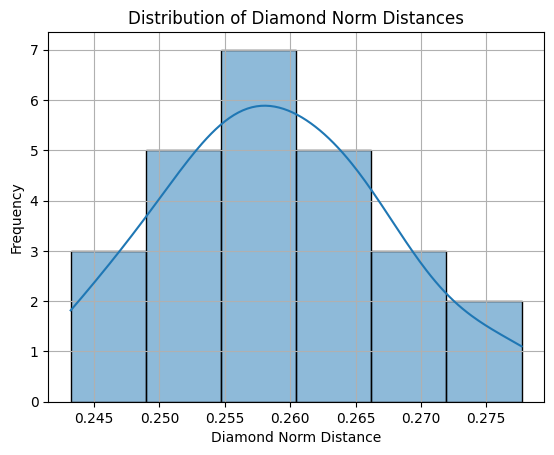

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_distance = np.mean(distances)
std_distance = np.std(distances)

print(f"Mean diamond norm distance: {mean_distance:.4f} ± {std_distance:.4f}")

# Optional: histogram of distances
sns.histplot(distances, kde=True)
plt.title("Distribution of Diamond Norm Distances")
plt.xlabel("Diamond Norm Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()